<a href="https://colab.research.google.com/github/dylanwalker/MGSC496/blob/main/MGSC496_L07_working.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This is the in-class notebook for MGSC496 Lecture 7.

In [1]:
%%capture
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader
!pip install yfinance

In [2]:
import numpy as np
import pandas as pd


Things to mention:
* If you hate indexes and esp multi-indexes, using `as_index=False` when doing `groupby` is a great option
* `.assign()` is a bit like `mutate()` in R/dplyr/tidyverse
* Using lambda functions is very useful when you want to:
 * assign new vars with `.assign()`
 * aggregate in more complicated ways with `.agg()`
 * apply a function to the dataframe with `.apply()` 


As a warm up, let's start by working on some data we haven't seen.

# Exercise: Who survived the Titanic?

Using data on the individuals that were on the Titanic and their attributes, let's try to figure out which attributes, if any were associated with survival.

To do this, we'll need to group the data in various ways and look at which percentage of individuals in the different groups survived.

We'll start by importing the data (which is included in the Seaborn plotting library) and looking at it:

In [3]:
import seaborn as sns

titanic = sns.load_dataset('titanic')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


The rows of the dataframe are individuals with these attributes:
* survival - Did the passenger survive (0 = No; 1 = Yes)
* pclass - Passenger class (1 = 1st; 2 = 2nd; 3 = 3rd)
* sex - Passenger's gender (male, female)
* age - Passenger's age
* sibsp - Number of siblings/spouses of the passenger aboard
* parch - Number of parents/children of the passenger aboard
* fare - What the passenger paid
* embarkeded - Port of embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
* class - Name of the class (referenced in pclass)
* who - Is the passenger a (man, woman, child)
* adult_male - Whether the passenger was an adult male (True, False)
* embark_town - Name of the port of embarkation (referenced in embarked)
* alive - Did the passenger survive as a yes/no string
* alone - Was the passenger alone (True, False)


If you want to get a sense of how the data is distributed across different non-numerical values in a column (`col`) of a dataframe (`df`), you can select that column and run `df.col.value_counts()`. If you want the percentage for each value, you can add the argument `normalize=True` to `value_counts()`. Give it a try with the columns:
* who
* embark_town

**1) How many passengers were there for each of the different values of the `who` column?**

In [27]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [28]:
# 1a. How many passengers were there for each of the different values of the "who" column?
titanic.who.value_counts()

man      537
woman    271
child     83
Name: who, dtype: int64

In [22]:
# 1b. What percentage of passengers were there for each of the different values of the "who" column?
titanic.who.value_counts(normalize=True)

man      0.602694
woman    0.304153
child    0.093154
Name: who, dtype: float64

In [20]:
pd.DataFrame(titanic.who.value_counts())

,who
man,537
woman,271
child,83


In [21]:
pd.DataFrame(titanic.who.value_counts()).assign(per = lambda df: df.who/df.who.sum())

,who,per
man,537,0.602694
woman,271,0.304153
child,83,0.093154


In [16]:
df2 = pd.DataFrame(titanic.who.value_counts())
df2

,who
man,537
woman,271
child,83


In [17]:
df2['per'] = df2.who / df2.who.sum()
df2

,who,per
man,537,0.602694
woman,271,0.304153
child,83,0.093154


**2) How many passengers were there for each of the different values of the `embark_town` column?**

In [24]:
# 2a. How many passengers were there for each of the different values of the "embark_town" column?
titanic.embark_town.value_counts()

Southampton    644
Cherbourg      168
Queenstown      77
Name: embark_town, dtype: int64

In [25]:
# 2b. What percentage of passengers were there for each of the different values of the "embark_town" column?
titanic.embark_town.value_counts(normalize=True)

Southampton    0.724409
Cherbourg      0.188976
Queenstown     0.086614
Name: embark_town, dtype: float64

We can use functions like `min`, `max`, `mean`, `std`, etc. on numerical columns. We can also use `.describe()` on those columns to get some basic stats.

**3) Do this for the column `age`**

In [32]:
# Try out basic functions such as min, max, mean, std, and describe on the age column
titanic.age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64

In [38]:
((titanic.alive=='yes')*1.0).mean()

0.3838383838383838

We want to explore grouping the passengers by their attributes to see which groups survived. To do this, we will take the dataframe and call `titanic.groupby('some_column')`. 

Using that as our starting point, we can then select our column of interest (e.g., `alive`) and do some further analysis on this column.

Typically, we aggegate over the values in each group and apply some function. The `alive` column is not numerical, so we can't apply a numerical function to it. We could of course call `value_counts()` on it. If we did we would end up with a multi-indexed dataframe, because we are grouping and `alive` can take more than one value. The index would be the `(group value, alive value)` and the value of each row would be the number of rows with that group value and alive value. 

For example, if we grouped by `sex`, selected the `alive` column and did `value_counts()` our index would be  (`male` or `female`, `yes` or `no`), so we would have 4 rows in the dataframe for the four possible values of the index. The values in each row would be the number of people in that combined group. We could also get the percentage instead of the number by using the `normalize=True` argument. Try it out now:


**4a) What percentage of male/female passengers survived? [grouping by sex, using alive column, and using value_counts() ]**

In [48]:
# group by column "sex", select the alive column and use value_counts() with and without the normalize=True argument:
titanic.groupby('sex').alive.value_counts(normalize=True).reset_index(name='percent')

,sex,alive,percent
0,female,yes,0.742038
1,female,no,0.257962
2,male,no,0.811092
3,male,yes,0.188908



HOWEVER... the column `survived` is a numerical version of the column `alive` -- it is 1 for rows where `alive` is `True` and 0 otherwise -- and we can apply numerical functions to this column. The average or **`mean`** of this column would be equal to the percentage that survived. 


**4b) What percentage of male/female passengers survived? [use survived column and mean() ]**

In [49]:
# use groupby(), select the correct column and use mean to determine the percentage of male and female passengers survived 
titanic.groupby('sex').survived.mean()

sex
female    0.742038
male      0.188908
Name: survived, dtype: float64

**5) What percentage of first,second and third class passengers survived?**

In [50]:
# use groupby() and value_counts(normalize=True) to determine which percentage of first, second and third class passengers survived
titanic.groupby('class').survived.mean()

class
First     0.629630
Second    0.472826
Third     0.242363
Name: survived, dtype: float64

**6) What percentage of passengers embarking from each of the different ports survived?**

In [51]:
# use groupby() and value_counts(normalize=True) to determine which percentage of passengers embarking from each of the different ports survived
titanic.groupby('embark_town').survived.mean()

embark_town
Cherbourg      0.553571
Queenstown     0.389610
Southampton    0.336957
Name: survived, dtype: float64

In [52]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [54]:
titanic.groupby('alone').survived.mean()

alone
False    0.505650
True     0.303538
Name: survived, dtype: float64

What if we wanted to look at the group of passengers that were both alone and adult males?  

We could make a new column in our dataframe like this:
```python
df['new_column_name'] = some operation that combines existing columns
```

**7) Define a new column called `alone_and_adult_male`and assign it a value by combining the existing `alone` column and the existing `who` column.**

Hints: 
* You can combine boolean columns using `&` (and) and `|` (or). 
* You can make a boolean column using the `==` expression on an existing column. For example: `(titanic.sex=='male')` will return a column of values that are `True` if for the rows that are `male` and `False` otherwise.   

In [55]:
# Make a new column "alone_and_adult_male" and assign its value by operating on the existing "alone" and "who" columns
titanic['alone_and_adult_male'] = (titanic.alone)&(titanic.who=='man')
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,alone_and_adult_male
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,False
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,True


**8) What percentage of alone adult males survived?**

In [56]:
# Try it out
titanic.groupby('alone_and_adult_male').survived.mean()

alone_and_adult_male
False    0.577963
True     0.156098
Name: survived, dtype: float64

**9a) Suppose you were a child on the titanic. Determine the probability of your survival depending on the number of parents you had on board.**

Hints:
* You can use `df.loc[(df.col == some_val), :]` to get all the rows for which `df.col` is equal to `some_val`. Use this to select only children as your first step.
* when the `who` is a `child`, the variable `parch` is the number of parents that child has on board.


In [57]:
titanic.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,alone_and_adult_male
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True,False
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True,True


In [66]:
# Try it out
titanic.loc[titanic.who=='child',:].groupby('parch').survived.mean()

parch
0    0.727273
1    0.641026
2    0.484848
Name: survived, dtype: float64

<font size=4 color="red">This is because parents are horrible. Prove me wrong for extra credit</font>

In [70]:
# Prove me wrong
titanic.loc[(titanic.who=='child')&(titanic.parch==2), :]

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone,alone_and_adult_male
43,1,2,female,3.00,1,2,41.5792,C,Second,child,False,NaN,Cherbourg,yes,False,False
58,1,2,female,5.00,1,2,27.7500,S,Second,child,False,NaN,Southampton,yes,False,False
59,0,3,male,11.00,5,2,46.9000,S,Third,child,False,NaN,Southampton,no,False,False
63,0,3,male,4.00,3,2,27.9000,S,Third,child,False,NaN,Southampton,no,False,False
78,1,2,male,0.83,0,2,29.0000,S,Second,child,False,NaN,Southampton,yes,False,False
119,0,3,female,2.00,4,2,31.2750,S,Third,child,False,NaN,Southampton,no,False,False
147,0,3,female,9.00,2,2,34.3750,S,Third,child,False,NaN,Southampton,no,False,False
165,1,3,male,9.00,0,2,20.5250,S,Third,child,False,NaN,Southampton,yes,False,False
182,0,3,male,9.00,4,2,31.3875,S,Third,child,False,NaN,Southampton,no,False,False
184,1,3,female,4.00,0,2,22.0250,S,Third,child,False,NaN,Southampton,yes,False,False


**9b) Select all the kids without parents in the dataframe, just to look at their characteristics.** 

In [ ]:
# Try it out

# Solution to Reading Exercise: Add an Adjusted Rating Column to the IMDb Dataframe 

First we'll read in and prepare the imdb dataframe (i.e., repeat all the little steps we took in the reading notebook to modify the imdb dataframe after we read it in):

In [71]:
# Read in the dataframe and preprocess it
imdbFile = 'https://raw.githubusercontent.com/dylanwalker/MGSC496/main/datasets/IMDB-Movie-Data.csv'
movies_df = pd.read_csv(imdbFile, index_col="Title")
movies_df.rename(columns={
        'Runtime (Minutes)': 'Runtime', 
        'Revenue (Millions)': 'Revenue_millions'
    }, inplace=True)
movies_df.columns = [col.lower() for col in movies_df]
movies_df["rating_category"] = movies_df["rating"].apply(lambda x: 'good' if x >= 8.0 else 'bad')

<hr/>
<img src="https://drive.google.com/uc?id=1sk8CSP26YY7sfyzmHGFXncuNRujkvu9v" align="left">

<font size=3 color="darkred">Make an Adjusted Rating Column for the IMDb dataframe </font>

<font>
In the imdb data that we've been looking at, the rating is just the mean score. But some movies have many more votes than others, and this should lend more "weight" to their rating. Let's make a new adjusted rating column that, for two movies with the same rating, will give higher rating to the movie that has received more votes.   
</font>


<font>

A good adjusted scoring rule is:
```
 rating_adjusted = rating - (rating - 5)*2**(-log10(votes+1))
```
(note: to implement this, we can use `np.log10()` )

You can see why adjusted rating might be a good idea. Suppose two movies have a rating of 8, but one has only 3 votes where the other has 4000 votes:
```
rating_adjusted_1 = 8 - (8-5)*2**(-log10(4)) = 6.02
rating_adjusted_2 = 8 - (8-5)*2**(-log10(4001)) = 7.75
```
The adjusted rating gives more weight to movies with more votes, because we are not as confident in ratings with few votes, and therefore adjust them towards the middel rating (5). Note that the adjustment (the part we are subtracting) gets smaller and smaller as the number of votes gets larger.

Let's try to add this adjusted rating to our imdb data frame. Make a new column called 'rating_adjusted' to implement this. Then, make a scatter plot of (rating_adjusted - rating) vs  rating.

note: it's okay if you want to make a column `rating_delta = rating_adjusted - rating`.

Now calculate the `rating_delta` and `rating_adjusted` and make a scatterplot with `rating` on the x-axis and `rating_delta` or `rating_adjusted` on the y-axis.
</font>

Now we can make our new adjusted rating column, based on the proposed adjusted rating:
```
 rating_adjusted = rating - (rating - 5)*2**(-log10(votes+1))
```

Here's my solution:

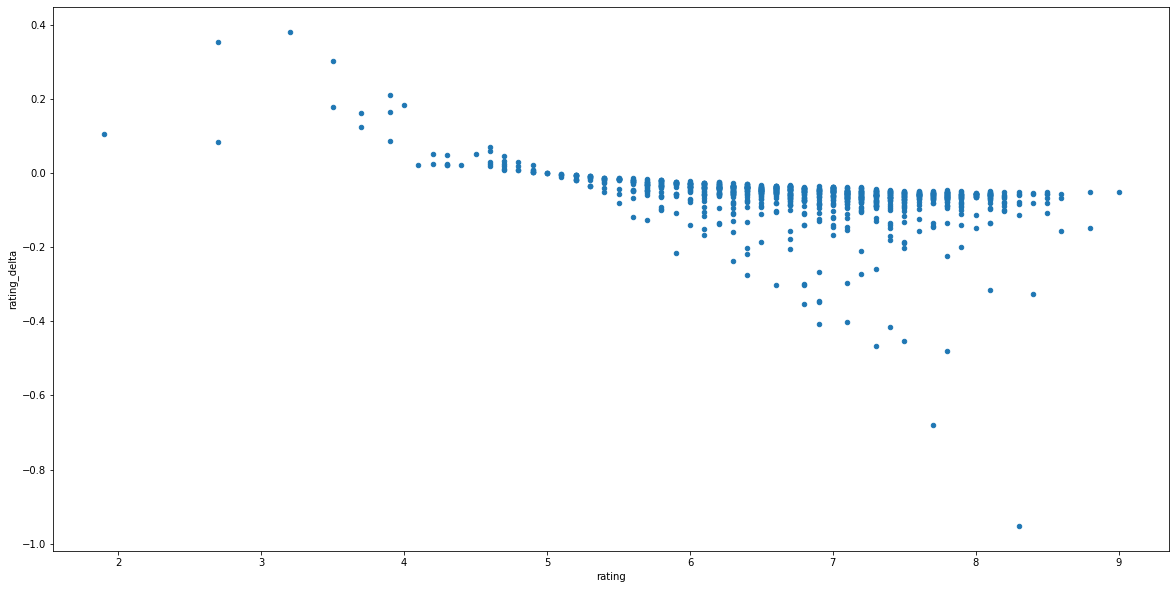

In [80]:
# Write your code here
movies_df.head()

# Solution using apply:
movies_df['rating_adjusted'] = movies_df.apply(lambda df: df['rating']-(df['rating']-5)*2**(-np.log10(df['votes']+1)), axis=1)

# Solution w/o using apply (better):
movies_df['rating_adjusted'] = movies_df.rating - (movies_df.rating-5)*2**(-np.log10(movies_df.votes+1))
movies_df['rating_delta'] = movies_df.rating_adjusted - movies_df.rating
movies_df.plot(kind='scatter', x='rating', y='rating_delta', figsize=(20,10));

In [77]:
movies_df.genre.str.split(',').explode()

Title
Guardians of the Galaxy       Action
Guardians of the Galaxy    Adventure
Guardians of the Galaxy       Sci-Fi
Prometheus                 Adventure
Prometheus                   Mystery
                             ...    
Search Party               Adventure
Search Party                  Comedy
Nine Lives                    Comedy
Nine Lives                    Family
Nine Lives                   Fantasy
Name: genre, Length: 2555, dtype: object

# Solution to Reading Exercise: Plot Revenue vs Adjusted Rating for a Single Genre 

<hr/>
<img src="https://drive.google.com/uc?id=1sk8CSP26YY7sfyzmHGFXncuNRujkvu9v" align="left">

<font size=3 color="darkred">Plot Revenue vs Adjusted Rating for a Single Genre</font>

<font>
Using the `movies_df` DataFrame, write a function that will plot the scatterplot of Revenue vs Metascore for only one Genre.
</font>

<br />
<br />
<br />

Your function should have two arguments:
- `movies_df`, the movie dataframe
- `genre`, a string sepcifying the Genre of movie for which we will plot the data, e.g., 'Horror'

Note that the an entry in the genre column contains a comma-separated list of different genres that a movie belongs to:



In [ ]:
movies_df.genre[1:10]

However, we can get all the individual unique genres by using Pandas built in string operations on a series:

In [ ]:
allGenresConcatenated = movies_df.genre.str.cat(sep=',') # This will return a string by concatenating all the strings in each row of genre, separating them with a ',' 
allGenres = np.unique(allGenresConcatenated.split(',')) # This will split the string so that we have a list and then use numpy's unique() to get only the unique elements of the list
allGenres

You may find the following string method of dataframes useful:
- If a dataframe `df` has a string columm, `stringCol`, then the method
 - `df.stringCol.str.contains(someString)` will return `True` if someString is a substring within a value of stringCol.

Your goal is to define a function that will return a plot object. The function should make a scatter plot of `rating_adjusted` on the x-axis and `revenue_millions` on the y-axis.

In [ ]:
def plot_rev_vs_rating_adj(movies_df, genreName):
  plot = movies_df[movies_df.genre.str.contains(genreName)].plot(kind='scatter',x='rating_adjusted',y='revenue_millions')
  plot.set_title(genreName)
  return plot

plot=plot_rev_vs_rating_adj('Horror')
plot=plot_rev_vs_rating_adj('Action')

# Solution to Reading Exercise: Cars, Cars, Cars    

<hr/>
<img src="https://drive.google.com/uc?id=1sk8CSP26YY7sfyzmHGFXncuNRujkvu9v" align="left">

<font size=3 color="darkred">Cars, Cars, Cars!</font>

<font>
Let's test our knowledge of merging, and concatenating by working with some datasets on cars.
</font>
<br />
<br />
<br />

First, let's read in some datasets with data about cars

In [ ]:
cars1 = pd.read_csv("https://raw.githubusercontent.com/dylanwalker/BA865/master/datasets/cars1.csv")
cars2_engine = pd.read_csv("https://raw.githubusercontent.com/dylanwalker/BA865/master/datasets/cars2_engine.csv")
cars2_perf = pd.read_csv("https://raw.githubusercontent.com/dylanwalker/BA865/master/datasets/cars2_perf.csv")
cars2_info = pd.read_csv("https://raw.githubusercontent.com/dylanwalker/BA865/master/datasets/cars2_info.csv")

display('cars1','cars2_engine','cars2_perf','cars2_info')

Q1: The first dataset `cars1` has some blank columns. Get rid of them:

In [ ]:
# write your code here
cars1 = cars1.loc[:, "mpg":"car"] # using .loc to slice only the columns we want to keep

Q2: Look at the number of observations in each of the datasets (cars1, cars2_perf, cars2_engine, cars2_info).  Do any of the datasets contain duplicate data? If so, clean them.

In [ ]:
# write your code here
cars1.drop_duplicates(inplace=True)
cars2_perf.drop_duplicates(inplace=True)
cars2_engine.drop_duplicates(inplace=True)
cars2_info.drop_duplicates(inplace=True)

Q3: Combine the data in cars2_engine, cars2_perf, and cars2_info into a single dataframe called cars2:

In [ ]:
# write your code here
cars2 = pd.merge(cars2_engine,cars2_perf)
cars2 = pd.merge(cars2,cars2_info)
cars2

Q4: Get rid of the extra unnamed column in cars2 and then combine the data in cars1 and cars2 together.

In [ ]:
# write your code here
cars2 = cars2.loc[:,"car":"origin"] # get rid of the unnamed column in cars2
cars = pd.concat([cars1,cars2] ,sort=True) # concatenate the cars1 and cars2 dataframes together
cars

# Solution to Reading Exercise: International Alcohol Consumption

In [ ]:

drinks = pd.read_csv('https://raw.githubusercontent.com/justmarkham/DAT8/master/data/drinks.csv')
drinks.head()

Q1: Which continent drinks more beer on average?

In [ ]:
# code your answer here
drinks.groupby('country').beer_servings.mean().sort_values(ascending=False)

Q2: For each continent, print the statistics for wine consumption:

In [ ]:
# code your answer here
drinks.groupby('continent').wine_servings.describe()

Q3: What is the mean alcohol consumption per contintent for every continent?

In [ ]:
# code your answer here
drinks.groupby('continent').total_litres_of_pure_alcohol.mean()

Q4: Using only one line of code, compute the mean, min and max spirit consumption per continent.

In [ ]:
# code your answer here
drinks.groupby('continent').spirit_servings.agg(['mean','min', 'max']).sort_values(['mean'],ascending=False) # the .sort_values() part is not necessary

# Solution to Reading Exercise: Does the number of planets detected by each method change over the years?

First we need to load the planets dataset:

In [ ]:
import seaborn as sns
planets = sns.load_dataset('planets')

<hr/>
<img src="https://drive.google.com/uc?id=1sk8CSP26YY7sfyzmHGFXncuNRujkvu9v" align="left">

<font size=3 color="darkred">Does the number of planets detected by each method change over the years?</font>

<font>
We want to know how the number of planets detected by each method changes over the years. What we're after is a dataframe where the index is a MultiIndex of (year, method) (where method is e.g., Radial Velocity, Pulsar Timing, etc.) and there is a column (that we'll name 'number') for the count for each year and method.
<br>
<br>
Once the dataframe is structured like this, we can just call `.plot()`.  if the figure is not sized correctly, try adding the keyword argument `figsize=(width,height)` and replace `width` and `height` by integers e.g. `figsize=(20,10)`.
<br>


Some hints:

* you'll need to group by more than one column to get the MultiIndex
* the order of the columns in the groupby matters, because we'll need to use `unstack()` to get the detection methods to become column labels.
</font>

In [ ]:
# We'll group by year and method and name the dataframe pmot_df for "(p)lanet (m)ethod (o)ver (t)ime"
pmot_df = planets.groupby(['year','method'])['number'].count() # this will produce a multiIndexed df where index is (year, method) and one column: count
pmot_df.unstack().plot(); # This will plot a series for each column vs the index (year)

<hr/>

# Exercise: Make a boxplot of movie revenue by each genre



For this exercise, we'll use `movies_df`, containing imdb movie data. Let's load that now (if its not already loaded):

In [ ]:
# Read in the dataframe and preprocess it
imdbFile = 'https://raw.githubusercontent.com/dylanwalker/MGSC496/main/datasets/IMDB-Movie-Data.csv'
movies_df = pd.read_csv(imdbFile, index_col="Title")
movies_df.rename(columns={
        'Runtime (Minutes)': 'Runtime', 
        'Revenue (Millions)': 'Revenue_millions'
    }, inplace=True)
movies_df.columns = [col.lower() for col in movies_df]
movies_df["rating_category"] = movies_df["rating"].apply(lambda x: 'good' if x >= 8.0 else 'bad')

What we'd like to do is make a boxplot with a box for each genre to show how the revenue is distributed for movies that are part of that genre.
<br>
<br>
Recall how the imdb movies data handles the fact that a movie could belong to one or more genres using a comma-separated string:


In [ ]:
movies_df[['genre']]

,genre
Title,
Guardians of the Galaxy,"Action,Adventure,Sci-Fi"
Prometheus,"Adventure,Mystery,Sci-Fi"
Split,"Horror,Thriller"
Sing,"Animation,Comedy,Family"
Suicide Squad,"Action,Adventure,Fantasy"
...,...
Secret in Their Eyes,"Crime,Drama,Mystery"
Hostel: Part II,Horror
Step Up 2: The Streets,"Drama,Music,Romance"


To make our boxplot, we need to get this dataframe into "long" format.  If the genre field was a list instead of a string, we would be in a similar situation as with the pets example. So how can we get it to be come a list?  

Pandas has some cool methods that let you work with columns that are strings.

In fact, many are vectorized versions of Pythons regular string methods:


|             |                  |                  |                  |
|-------------|------------------|------------------|------------------|
|``len()``    | ``lower()``      | ``translate()``  | ``islower()``    | 
|``ljust()``  | ``upper()``      | ``startswith()`` | ``isupper()``    | 
|``rjust()``  | ``find()``       | ``endswith()``   | ``isnumeric()``  | 
|``center()`` | ``rfind()``      | ``isalnum()``    | ``isdecimal()``  | 
|``zfill()``  | ``index()``      | ``isalpha()``    | ``split()``      | 
|``strip()``  | ``rindex()``     | ``isdigit()``    | ``rsplit()``     | 
|``rstrip()`` | ``capitalize()`` | ``isspace()``    | ``partition()``  | 
|``lstrip()`` |  ``swapcase()``  |  ``istitle()``   | ``rpartition()`` |

But they also have methods for pattern matching with regular expressions:

| Method | Description |
|--------|-------------|
| ``match()`` | Call ``re.match()`` on each element, returning a boolean. |
| ``extract()`` | Call ``re.match()`` on each element, returning matched groups as strings.|
| ``findall()`` | Call ``re.findall()`` on each element |
| ``replace()`` | Replace occurrences of pattern with some other string|
| ``contains()`` | Call ``re.search()`` on each element, returning a boolean |
| ``count()`` | Count occurrences of pattern|
| ``split()``   | Equivalent to ``str.split()``, but accepts regexps |
| ``rsplit()`` | Equivalent to ``str.rsplit()``, but accepts regexps |

I mentions these not only because they are very useful when working with text data, but also because we can use them for this exercise in order to take the genre, which is a string of comma-separated genre names, and convert it into a list.

Here's how:


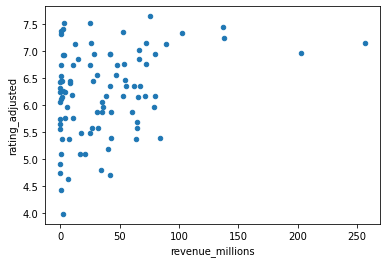

In [82]:
movies_df.loc[movies_df.genre.str.contains('Horror'),:].plot(kind='scatter',x='revenue_millions',y="rating_adjusted");

In [ ]:
movies_df.genre.str.split(',')

Title
Guardians of the Galaxy     [Action, Adventure, Sci-Fi]
Prometheus                 [Adventure, Mystery, Sci-Fi]
Split                                [Horror, Thriller]
Sing                        [Animation, Comedy, Family]
Suicide Squad              [Action, Adventure, Fantasy]
                                       ...             
Secret in Their Eyes            [Crime, Drama, Mystery]
Hostel: Part II                                [Horror]
Step Up 2: The Streets          [Drama, Music, Romance]
Search Party                        [Adventure, Comedy]
Nine Lives                    [Comedy, Family, Fantasy]
Name: genre, Length: 1000, dtype: object

We can actually make this a new column of our dataframe. Lets call it "genre_list":

In [ ]:
movies_df['genre_list'] = movies_df.genre.str.split(',')
movies_df

,rank,genre,description,director,actors,year,runtime,rating,votes,revenue_millions,metascore,rating_category,genre_list
Title,,,,,,,,,,,,,
Guardians of the Galaxy,1,"Action,Adventure,Sci-Fi",A group of intergalactic criminals are forced ...,James Gunn,"Chris Pratt, Vin Diesel, Bradley Cooper, Zoe S...",2014,121,8.1,757074,333.13,76.0,good,"[Action, Adventure, Sci-Fi]"
Prometheus,2,"Adventure,Mystery,Sci-Fi","Following clues to the origin of mankind, a te...",Ridley Scott,"Noomi Rapace, Logan Marshall-Green, Michael Fa...",2012,124,7.0,485820,126.46,65.0,bad,"[Adventure, Mystery, Sci-Fi]"
Split,3,"Horror,Thriller",Three girls are kidnapped by a man with a diag...,M. Night Shyamalan,"James McAvoy, Anya Taylor-Joy, Haley Lu Richar...",2016,117,7.3,157606,138.12,62.0,bad,"[Horror, Thriller]"
Sing,4,"Animation,Comedy,Family","In a city of humanoid animals, a hustling thea...",Christophe Lourdelet,"Matthew McConaughey,Reese Witherspoon, Seth Ma...",2016,108,7.2,60545,270.32,59.0,bad,"[Animation, Comedy, Family]"
Suicide Squad,5,"Action,Adventure,Fantasy",A secret government agency recruits some of th...,David Ayer,"Will Smith, Jared Leto, Margot Robbie, Viola D...",2016,123,6.2,393727,325.02,40.0,bad,"[Action, Adventure, Fantasy]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
Secret in Their Eyes,996,"Crime,Drama,Mystery","A tight-knit team of rising investigators, alo...",Billy Ray,"Chiwetel Ejiofor, Nicole Kidman, Julia Roberts...",2015,111,6.2,27585,NaN,45.0,bad,"[Crime, Drama, Mystery]"
Hostel: Part II,997,Horror,Three American college students studying abroa...,Eli Roth,"Lauren German, Heather Matarazzo, Bijou Philli...",2007,94,5.5,73152,17.54,46.0,bad,[Horror]
Step Up 2: The Streets,998,"Drama,Music,Romance",Romantic sparks occur between two dance studen...,Jon M. Chu,"Robert Hoffman, Briana Evigan, Cassie Ventura,...",2008,98,6.2,70699,58.01,50.0,bad,"[Drama, Music, Romance]"


Ok, now you're ready to go!  In order to make the boxplot, you'll need to:
- use `.explode()` to get the genre_list into long format.
- use `.boxplot()` with the appropriate `column` and `by` keyword arguments.
- I'd also suggest adding a `figsize=(40,8)` argument to `.boxplot()` because this figure will need to be fairly wide.

In [ ]:
# Input your code here

## Solution -- Don't look until you've tried it!

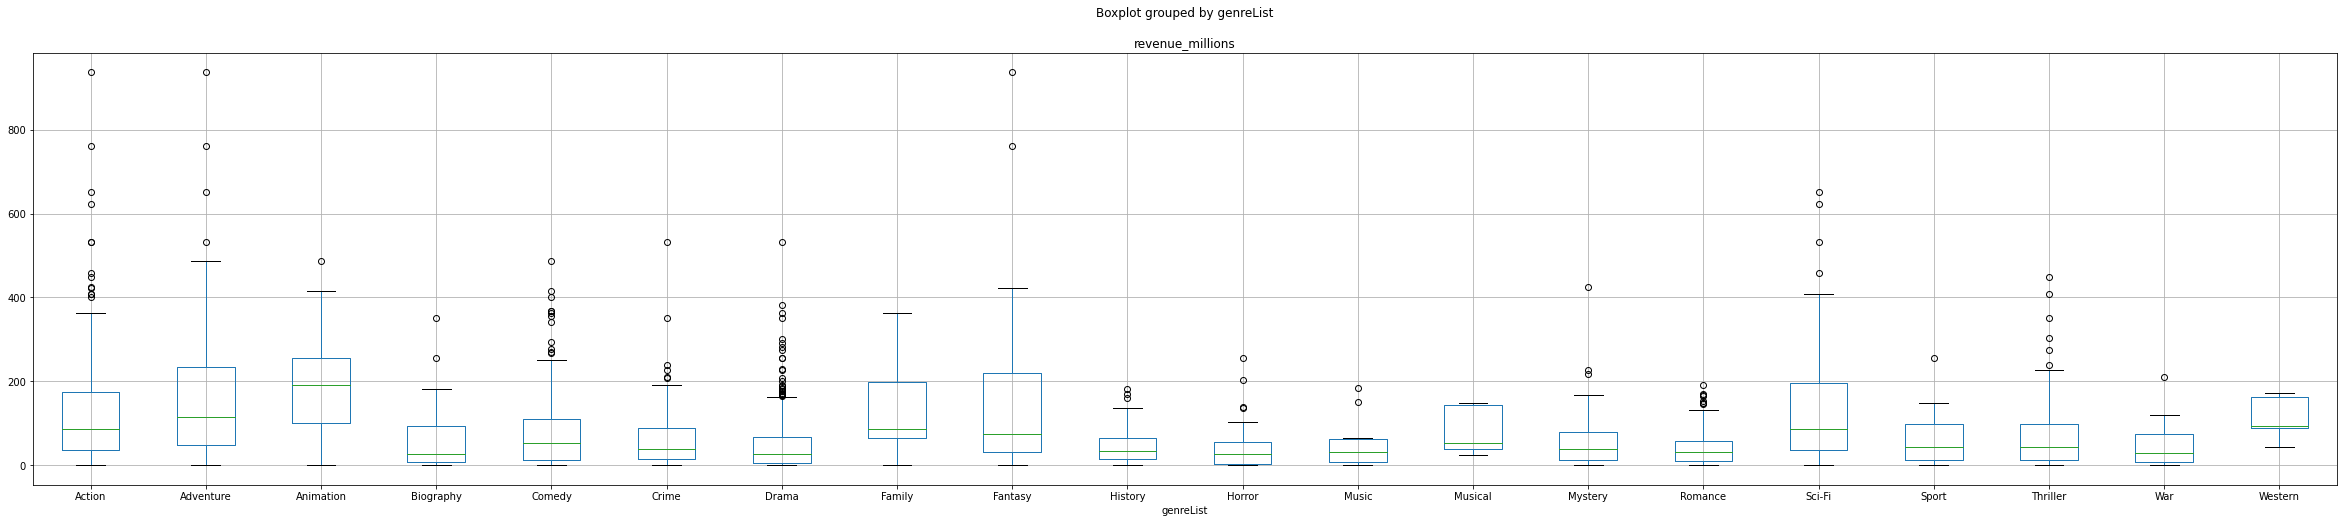

In [ ]:
# SOLUTION: 
mdf = movies_df.copy()
mdf['genreList'] = movies_df.genre.apply(lambda x: x.split(',')) # make a genre column that is a list instead of a comma-separated string
mdf['genreList'] = movies_df.genre.str.split(',') # this does the same thing with a string methbod

# Now we can use the 'explode' method which will take a list column and turn it into a bunch of rows
mdf[['revenue_millions','rating','genreList']].explode('genreList').boxplot(column='revenue_millions',by='genreList',figsize=(40,8));